## **Task**

Develop code for the weighted sum method and, using this code, find the Pareto front, a set of efficient solutions to minimize the risk and maximize the return simultaneously.     

Consider different types of risk functions.

In [1]:
import pandas as pd
import numpy as np

num_assets = 50 # number of assets
capital = 100000 # capital to invest

cov_matrix = pd.read_excel('omf_all_data.xlsx', sheet_name='Covariance Matrix', index_col=0)
# fill the upper triangle of the covariance matrix
covariance_matrix = cov_matrix.fillna(cov_matrix.T)
covariance_matrix = covariance_matrix.values

# matrix of 1s
e = np.array([[1] for _ in range(num_assets)])

# expected rate of return
mu = pd.read_excel('omf_all_data.xlsx', sheet_name='Expected rate of return, E(ri)', index_col=0)
mu = mu.values
mu = mu.T

**Objective**
Minimize w1 *  wTΩ w  - w2 *  muT w  
subject to  
    eTw=1,  
    short selling is allowed

**Solution**
Using a solver

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-14


C:\Users\Ayush\AppData\Local\Temp\ipykernel_23008\2956083134.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  portfolio_return = gp.quicksum(weights[i] * returns[i] for i in range(len(returns)))


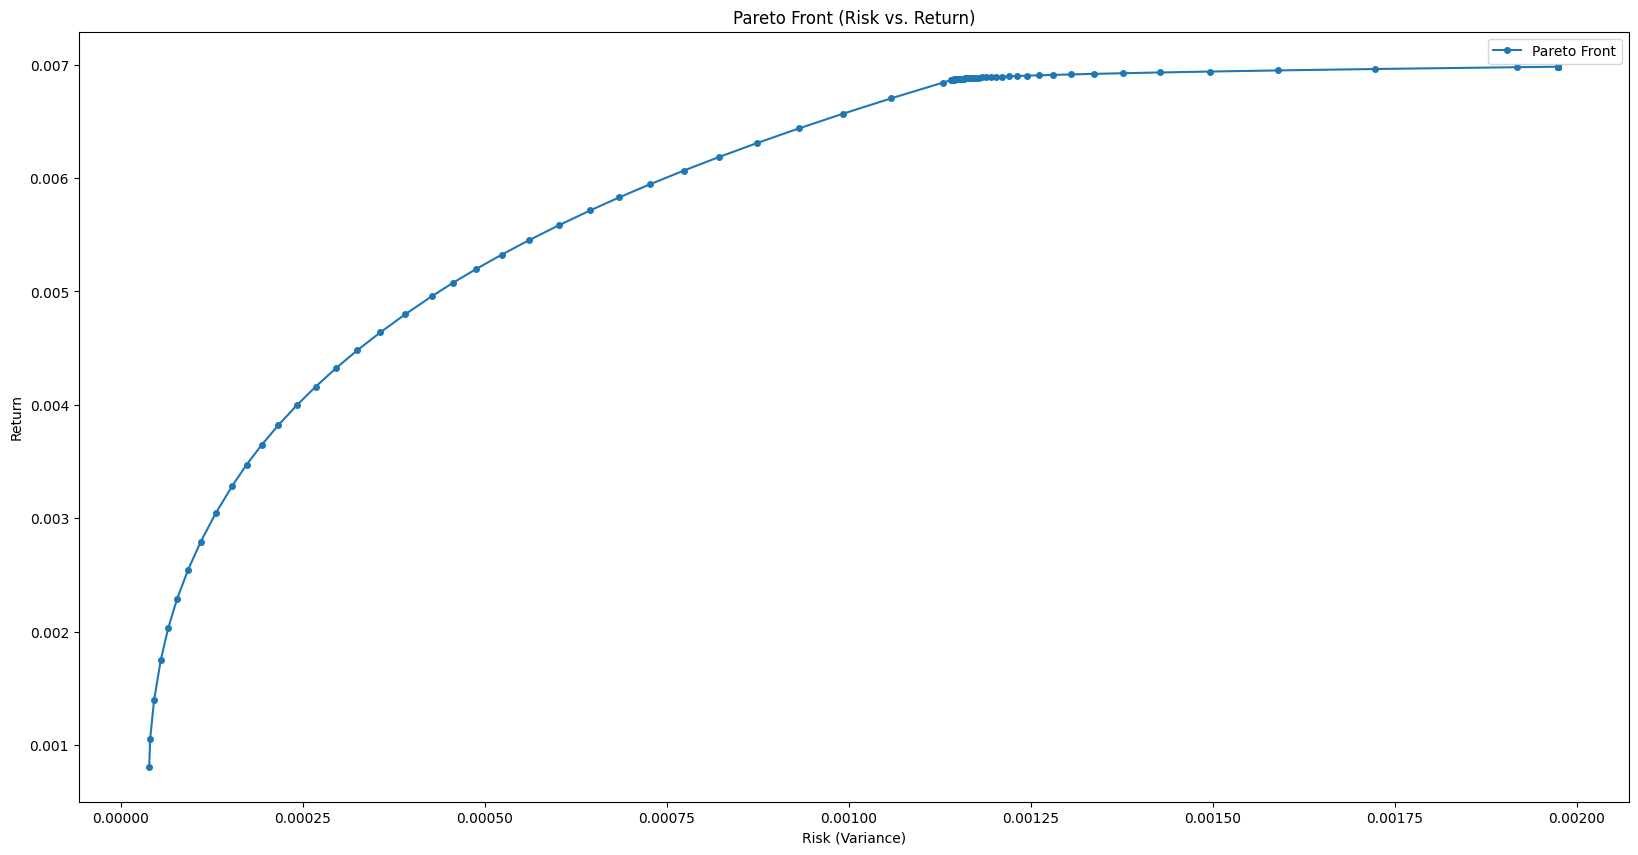

In [2]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt

# Example returns and risk (covariance matrix) for 5 assets
returns = mu  # Expected returns of assets
cov_matrix = covariance_matrix  # Covariance matrix as risk

# Set up the Pareto front calculation
def calculate_pareto_front():
    solutions = []
    for alpha in np.linspace(0, 1, 100):  # Vary alpha to generate Pareto front
        try:
            # Create a new Gurobi model
            model = gp.Model("weighted_sum_method")
            model.setParam('OutputFlag', 0)  # Turn off Gurobi output
            
            # Add variables for the weights of each asset in the portfolio
            weights = model.addVars(len(returns), lb=0, ub=1, name="weights")
            
            # Set the constraint that weights must sum to 1
            model.addConstr(gp.quicksum(weights[i] for i in range(len(returns))) == 1, "budget")

            # Define portfolio return and risk
            portfolio_return = gp.quicksum(weights[i] * returns[i] for i in range(len(returns)))
            portfolio_risk = gp.quicksum(weights[i] * cov_matrix[i, j] * weights[j] 
                                         for i in range(len(returns)) for j in range(len(returns)))
            
            # Set the weighted sum objective
            model.setObjective(-alpha * portfolio_return + (1 - alpha) * portfolio_risk, GRB.MINIMIZE)

            # Optimize the model
            model.optimize()

            # Collect solutions if optimal
            if model.status == GRB.OPTIMAL:
                w_values = [weights[i].x for i in range(len(returns))]
                optimal_return = sum(w * r for w, r in zip(w_values, returns))[0]
                optimal_risk = sum(w_values[i] * cov_matrix[i, j] * w_values[j] 
                                   for i in range(len(returns)) for j in range(len(returns)))
                solutions.append((optimal_risk, optimal_return))
                # print(f"Alpha: {alpha:.2f} - Return: {optimal_return}, Risk: {optimal_risk}")

        except gp.GurobiError as e:
            print(f"Error code {e.errno}: {e}")
            break
    
    return np.array(solutions)

# Calculate and plot the Pareto front
pareto_front = calculate_pareto_front()


plt.figure(figsize=(20, 10))
plt.plot(pareto_front[:, 0], pareto_front[:, 1], 'o-', markersize=4, label="Pareto Front")
plt.xlabel("Risk (Variance)")
plt.ylabel("Return")
plt.title("Pareto Front (Risk vs. Return)")
plt.legend()
plt.show();
